# Bioremediation of a coastal oil spill: A case study using a community genome-scale metabolic model

<img src="imgs/banner.png" alt="Image Description" style="width:100%; max-height:200px;">

Oil spills are among the most devastating environmental disasters, posing significant threats to marine ecosystems. The aftermath of such spills sees a [surge in microbial communities](https://www.frontiersin.org/articles/10.3389/fmicb.2021.633659/full) capable of degrading the hydrocarbons present in the oil. These communities form intricate trophic networks, with various species playing specific roles in the degradation process. By harnessing the potential of these communities, we can develop effective bioremediation strategies to mitigate the impact of oil spills. Specifically, we can employ community metabolic models to investigate which species and trophic relations are key to the degradation process. Armed with this knowledge, we can engineer microbial communities, designing [bioaugmentation](https://en.wikipedia.org/wiki/Bioaugmentation) or [biostimulation](https://en.wikipedia.org/wiki/Biostimulation) strategies to enhance their bioremediation potential.

In this Jupyter Notebook, we will use a community genome-scale metabolic model to investigate the trophic network that emerges post a marine coastal oil spill. Additionally, we will employ constraint-based modeling techniques, such as [Flux Balance Analysis (FBA)](https://en.wikipedia.org/wiki/Flux_balance_analysis) and [elasticities](https://en.wikipedia.org/wiki/Price_elasticity_of_demand) to identify both taxa and environmental nutrients that bear the potential to improve the degradation of toxic compounds. Finally, based on the gained knowledge, we will design a biostimulation strategy by adding key nutrients to he medium to enhance the bioremediation potential of the community.

## The community and the environment

The community consists of six bacterial species, which are [known to be involved](https://www.frontiersin.org/articles/10.3389/fmicb.2021.633659/full) in the degradation of toluene. The involved genera are:

- *Alcanivorax*
- *Pseudomonas*
- *Acinetobacter*
- *Marinobacter*
- *Thalassospira*
- *Pseudomonas*

We will simulate a marine medium with three representatives of carbon sources that are commonly found in surface waters, we will use:

- *Glycogen*, which is the main storage polymer in cyanobacteria, and as much as [100-fold more abundant](https://ami-journals.onlinelibrary.wiley.com/doi/full/10.1111/1462-2920.14302) than other phytoplankton exudates, such as free monosaccharides or amino acids. 
- *Glycinebetaine*, which is [highly abundant](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9321204/) in marine environments.
- *D-Xylulose*, as representative of the degradation of microalgal polysaccharides.

Finally, we will add *Toluene*, one of the [most abundant and toxic compounds](https://www.researchsquare.com/article/rs-3200599/v1) in crude oil, as a representative compound of the oil spill.

## Relevant tools

We will use the following tools to perform the analysis:

* [MICOM](https://github.com/micom-dev/micom): a computational tool used for constructing and analyzing community genome-scale metabolic models. It allows for the integration of individual metabolic models, each representing a different bacterial genus, into a unified community model. This approach enables the study of metabolic interactions within microbial communities, providing insights into their collective functionality and resilience.

* [Cobrapy](https://github.com/opencobra/cobrapy): a Python library used for genome-scale metabolic modeling. It provides a simple interface to create, manipulate, and simulate biological networks for systems biology. This tool is widely used in bioinformatics and computational biology for studying metabolic behaviors of organisms.

* [NetworkX](https://github.com/networkx): a Python library for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks. It provides data structures for graphs along with graph algorithms, generators, and drawing tools. The library is widely used in network analysis across various fields such as bioinformatics, social network analysis, and transportation networks.

## Building the Community Model

To construct a community genome-scale model, we first need to obtain individual genome-scale metabolic models (GEMs) for each bacterial genus in our community, and then we will combine them into a unified community model. In our case, we will obtain those from [MICOM's model database](https://zenodo.org/records/3755182). The GEMs in this database were reconstructed using [CarveMe](https://academic.oup.com/bioinformatics/article/34/17/3038/4999126) -- a tool to reconstruct GEMs out of genomes and a universal metabolic model -- and representative prokaryotic genomes of each genera obtained from refseq. For convenience, you can find individual GEMs employed in this notebook in the directory named `models`.

__NOTE__: In a real-case escenario, we could directly reconstruct GEMs from metagenome-assembled genomes (MAGs) isolated from the oil spill site.

To construct the community model, we will assemble the individual GEMs into a larger, unified model, which will contain an additional space with shared extracellular metabolites as well as a community biomass pseudoreaction (besides the individual biomass reactions present in each GEM). To this end, we will employ the `build` workflow from the Micom toolbox.

MICOM requires a configuration file to run the `build` workflow. This file contains the ID and path to the individual GEMs. Additionally, MICOM requires a measure of relative abundance for each member in the community. This is because flux predictions of each individual member are scaled by their relative abundance so fluxes are coherent across the community. In our case, we will assume that all genera have equal abundances. Note that MICOM also allows updating relative abundances after the model have been built. You can find the configuration file for this notebook in `data/micom_database.tsv`.

In [1]:
import pandas as pd

taxo_df = pd.read_csv("data/micom_database.csv", sep=",", index_col=None)
taxo_df

,sample_id,id,abundance,file
0,oilspill,Acinetobacter,100,models/Acinetobacter.json
1,oilspill,Alcanivorax,100,models/Alcanivorax.json
2,oilspill,Alteromonas,100,models/Alteromonas.json
3,oilspill,Flavobacterium,100,models/Flavobacterium.json
4,oilspill,Marinobacter,100,models/Marinobacter.json
5,oilspill,Oleibacter,100,models/Oleibacter.json
6,oilspill,Polaribacter,100,models/Polaribacter.json
7,oilspill,Pseudomonas,100,models/Pseudomonas.json
8,oilspill,Rhodococcus,100,models/Rhodococcus.json
9,oilspill,Thalassospira,100,models/Thalassospira.json


Alright, let's get started by building the community model! The output of the `build` pipeline is a pickle file that stores the complete community model for subsequent analysis. If you prefer to proceed directly to analysis, you may use the pre-built community model available in the `data` folder as a pickle file.

In [2]:
from micom.workflows import build

manifest = build(taxonomy=taxo_df, model_db=None, out_folder="results/micom", cutoff=1e-2, threads=14 , solver="gurobi")

[21:22:28] WARNING  Found existing models for 1 samples. Will skip those. Delete the output folder if   ]8;id=147671;file:///home/robaina/miniconda3/envs/phycogem/lib/python3.11/site-packages/micom/workflows/build.py\build.py]8;;\:]8;id=649073;file:///home/robaina/miniconda3/envs/phycogem/lib/python3.11/site-packages/micom/workflows/build.py#95\95]8;;\
                    you would like me to rebuild them.                                                             

Output()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-05


Read LP format model from file /tmp/tmpofj8qnou.lp
Reading time = 0.12 seconds
: 15669 rows, 49781 columns, 209395 nonzeros


Let's check the community model that we have just built. As we can see below, the model is composed of all 10 individual GEMs, an aggregated number of over 24800 reactions and over 15600 metablites. Additionally, MICOM has generated a community-wide biomass reaction, which is the default optimization objective (`community_objective`).

In [3]:
from micom import load_pickle

cgem = load_pickle("results/micom/oilspill.pickle")
cgem

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-05
Read LP format model from file /tmp/tmpjkt7mjym.lp
Reading time = 0.13 seconds
: 15669 rows, 49781 columns, 209395 nonzeros


Name,oilspill
Memory address,7f79d172d750
Number of metabolites,15658
Number of reactions,24890
Number of genes,11823
Number of groups,0
Objective expression,1.0*community_objective
Compartments,"C_c__Acinetobacter, C_p__Acinetobacter, C_e__Acinetobacter, m, C_c__Alcanivorax, C_e__Alcanivorax, C_p__Alcanivorax, C_c__Alteromonas, C_p__Alteromonas, C_e__Alteromonas, C_e__Flavobacterium, C_p__Flavobacterium, C_c__Flavobacterium, C_c__Marinobacter, C_p__Marinobacter, C_e__Marinobacter, C_c__Oleibacter, C_p__Oleibacter, C_e__Oleibacter, C_c__Polaribacter, C_p__Polaribacter, C_e__Polaribacter, C_c__Pseudomonas, C_p__Pseudomonas, C_e__Pseudomonas, C_c__Rhodococcus, C_p__Rhodococcus, C_e__Rhodococcus, C_c__Thalassospira, C_p__Thalassospira, C_e__Thalassospira"


## Preparing the medium for the simulation

Next, we will load the medium employed to simulate the oil spill. Specifically, we will use a marine medium, containing salts and some essential cofactors, such as thiamin. As mentioned earlier, the medium contains three carbon sources, which are commonly found in surface waters, and toluene, as a representative compound of the oil spill.

The medium is stored in `data/oilspill_medium.tsv`, which contains two columns. The first column contains the reaction IDs corresponding to the exchange reactions in the community model that uptake the specific compound from the medium. The second column correspond to the maximum allowed uptake rate for each compound, in units of mmol/gDW/h. Note that, while the maximum flux is positive in this file, the standard in constraint-based modeling is to use negative values for uptake reactions. MICOM (and cobrapy under the hood) will take care of this for us.

In [4]:
import pandas as pd

medium = pd.read_csv('data/oilspill_medium.tsv', sep='\t', header=None)
medium.columns = ["reaction", "flux"]
medium.set_index('reaction', inplace=False)
medium = medium[medium.reaction.isin([r.id for r in cgem.exchanges])]

## Optimizing community growth

Now that we have establish the growth medium, we are ready to run our first simulation. We will begin by maximizing community growth through regular FBA. While optimizing growth is not the focus of this Notebook, as we don't need it for our analysis, we will do it anyway just to check that the model is working as expected.

In [5]:
cgem.medium = medium.set_index('reaction').squeeze()
cgem.optimize()

,abundance,growth_rate,reactions,metabolites
compartments,,,,
Acinetobacter,0.1,0.009151,2904,1747
Alcanivorax,0.1,0.000000,2005,1329
Alteromonas,0.1,0.000000,2308,1509
Flavobacterium,0.1,4.195706,2868,1679
Marinobacter,0.1,0.000000,2761,1654
...,...,...,...,...
Polaribacter,0.1,0.000000,1973,1311
Pseudomonas,0.1,0.445514,3277,1869
Rhodococcus,0.1,0.000000,2639,1548


As shown above, the community grows with a maximum rate of $0.465 \;h^{-1}$ in this medium. Additionally, we see that not all members have positive individual growth rates in the simulation. This is result of employing regular FBA, i.e., simply maximizing the community biomass reaction without considering individual growth. To address this issue, MICOM provides cooperative tradeoff algorithm, which optimizes both community and individual growth rates simulatneously by means of a tradeoff parameter between the two objectives. We will optimize growth in this way for comparison purposes, employing a tradeoff value of $0.5$.

__NOTE__: Running cooperative_tradeoff can take a while for large models such as this one. You can safely skip the following cell as we won't need these results for the rest of the analysis.

In [6]:
cgem.cooperative_tradeoff(fraction=0.5)

,abundance,growth_rate,reactions,metabolites
compartments,,,,
Acinetobacter,0.1,0.142397,2904,1747
Alcanivorax,0.1,0.212791,2005,1329
Alteromonas,0.1,0.191224,2308,1509
Flavobacterium,0.1,0.208701,2868,1679
Marinobacter,0.1,0.094519,2761,1654
...,...,...,...,...
Polaribacter,0.1,0.213886,1973,1311
Pseudomonas,0.1,0.112314,3277,1869
Rhodococcus,0.1,0.157577,2639,1548


After running the `cooperative_tradeoff` algorithm, we can clearly see that all members have now positive growth rates. However, the community growth rate has decreased to $0.233 \;h^{-1}$. This is expected, because the algorithm is now optimizing both community and individual growth rates, which are competing objectives. In this case, the algorithm has found a tradeoff between the two objectives, which results in a suboptimal, and likely more realistic, community growth rate. Ok, now that we have checked that the model is working as expected, let's move on to the analysis of the trophic network.

## Analyzing trophic interactions among community members

We will now use the community model to explore the metabolic interactions between the different species. To this end, we will use micom's `grow` workflow, which will simulate the growth of the community on the different carbon sources in the provided medium, including the pollutant toluene. To do so, the workflow will use the cooperative growth algorithm that we saw before, with a tradeoff parameter between community and individual growth rates of $0.5$. The workflow will output dataframe containing the fluxes through all exchange reactions sharing metabolites among community members. We will use these results to visualize the network of trophic interactions among members, and, hopefully identifying the genera directly responsible for toluene uptake and degradation.

To speed up the proces, you may skip the following cell and use the pre-computed results stored in `results/micom/exchanges.tsv`.

In [7]:
from micom.workflows import grow

res = grow(manifest, model_folder="results/micom/", medium=medium, tradeoff=0.5, threads=14)
res.exchanges[res.exchanges.taxon != 'medium'].to_csv("results/micom/exchanges.tsv", sep="\t")

Output()

Read LP format model from file /tmp/tmpkhcknk1l.lp
Reading time = 0.12 seconds
: 15669 rows, 49781 columns, 209395 nonzeros


In [8]:
exchanges_df = pd.read_csv("results/micom/exchanges.tsv", sep="\t", index_col=0)
exchanges_df.head()

,taxon,sample_id,tolerance,reaction,flux,abundance,metabolite,direction
0,Acinetobacter,oilspill,0.000001,EX_acald_e,119.564028,0.1,acald_e,export
8,Acinetobacter,oilspill,0.000001,EX_glyclt_e,0.000475,0.1,glyclt_e,export
17,Acinetobacter,oilspill,0.000001,EX_xtsn_e,0.220739,0.1,xtsn_e,export
20,Acinetobacter,oilspill,0.000001,EX_h2o_e,56.408066,0.1,h2o_e,export
21,Acinetobacter,oilspill,0.000001,EX_pacald_e,-100.000000,0.1,pacald_e,import


From the results above,it seems like there are indeed trophic interactions amomng community members. The table above lists the compounds that are being shared in the field `reaction`, corresponding to the exchange reaction importing from or exporting the compound to the medium. Additionally, it indices import (negative flux) or export (positive flux) of the compound in the field `flux`. Finally, the field `taxon` indicates the member that is importing or exporting the compound. Note that this table  contains all compounds which are present in the medium, including the orginal compounds from which the community started to grow as well as the new compounds synthetized and excreted by the community. 

### Representing the trophic network as a bipartite graph

To simplify the analysis, let's next represent these trophic relations as a bipartite graph. In this graph, nodes represent either the compounds or the community members, and edges represent the trophic interactions between them. We will use the `networkx` library to create and visualize the graph. Additionally, we will plot only a selected subset of taxa to simplify the visualization.

In [9]:
from src.helper_functions import (
    generate_bipartite_graph,
    get_donor_receiver_from_exchanges,
    get_used_medium_sources
    )

selected_taxa = [
    "Acinetobacter", "Pseudomonas", "Alteromonas",
    "Thalassospira", "Marinobacter"
]

hidden_metabolites = [
    'h', 'h2', 'btn', 'ca2', 'cl', 'co2',
    'cu2', 'fe2', 'fe3', 'k', 'no2', 'no3',
    'so4', 'thm', 'zn2', 'pi', 'h2o', 'o2',
    'cobalt2', 'nh4', 'hco3', 'mg2', 'mn2'
    ]

# Prepare bipartite graph
donor_receiver_df = get_donor_receiver_from_exchanges(exchanges_df)
donor_receiver_df.loc[:, "compound"] = donor_receiver_df[
    "compound"
    ].str.replace("glycogen1500_m", "glycog_m") # Simplify glycogen ID
used_medium_sources = get_used_medium_sources(donor_receiver_df)

exchanges_file_path = "results/micom/exchanges.tsv"
all_taxa = taxo_df["id"].tolist()
hidden_taxa = [taxon for taxon in all_taxa if taxon not in selected_taxa]

bipartite_graph = generate_bipartite_graph(
    exchanges_file_path,
    hide_taxa=hidden_taxa,
    hide_metabolites=hidden_metabolites,
    keep_metabolites=["bz"],
    flux_cutoff=0.0,
    target_taxon="Acinetobacter",
    environmental_carbon_sources=used_medium_sources,
    relabel_nodes={"glycogen1500": "glycog"},
    output_graph="results/micom/bipartite_graph.json",
    )

### Plotting the trophic network

Finally, we will employ `networkx` to plot the bipartite graph that we generated before. We will use a shell layout, where the two node classes, compound and taxon, are placed in two concentric circles. Compound nodes will be placed in the extneral circle, and taxon node in the internal one to facilitate the visualization of the edges.

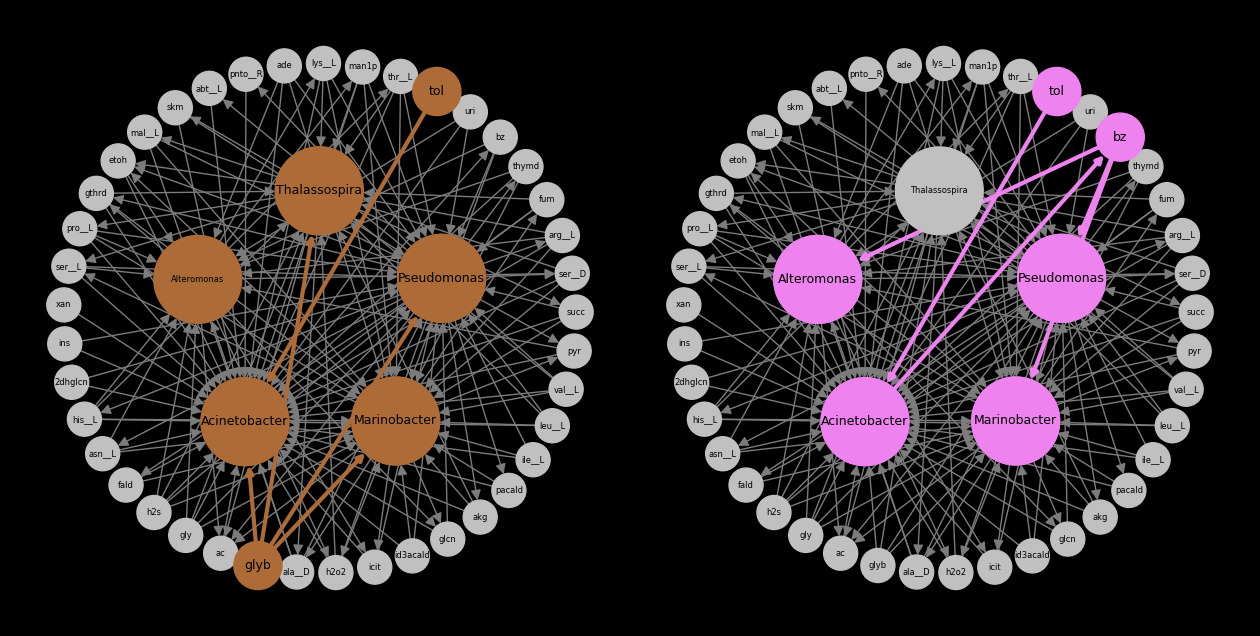

In [10]:
# import random
from matplotlib import pyplot as plt
from src.helper_functions import plot_trophic_interactions

environmental_carbon_sources = used_medium_sources
color_other_edges = '#7c7c7c'
color_other_nodes = 'silver'
target_taxon = 'Acinetobacter'
large_node_size = 4000
small_node_size = 600
edge_width_target_taxon = 3.0
edge_width_other = 1.0
arrow_size_target_taxon = 10
arrow_size_other = 15
font_size = 6
seed = 82 #random.randint(0, 100)
# print(f"seed is {seed}")

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
plot_trophic_interactions(
    bipartite_graph=bipartite_graph,
    environmental_carbon_sources=environmental_carbon_sources,
    ax=axs[0],
    highlight_compounds=["glycog", "dxyl", "glyb", "tol"],
    target_taxon=target_taxon,
    color_oil_nodes='#ad6c37',
    color_other_edges=color_other_edges,
    color_other_nodes=color_other_nodes,
    large_node_size=large_node_size,
    small_node_size=small_node_size,
    edge_width_target_taxon=edge_width_target_taxon,
    edge_width_other=edge_width_other,
    arrow_size_target_taxon=arrow_size_target_taxon,
    arrow_size_other=arrow_size_other,
    font_size=font_size,
    seed=seed
)
plot_trophic_interactions(
    bipartite_graph=bipartite_graph,
    environmental_carbon_sources=environmental_carbon_sources,
    ax=axs[1],
    highlight_compounds=["tol", "bz"],
    target_taxon=target_taxon,
    color_oil_nodes='violet',
    color_other_edges=color_other_edges,
    color_other_nodes=color_other_nodes,
    large_node_size=large_node_size,
    small_node_size=small_node_size,
    edge_width_target_taxon=edge_width_target_taxon,
    edge_width_other=edge_width_other,
    arrow_size_target_taxon=arrow_size_target_taxon,
    arrow_size_other=arrow_size_other,
    font_size=font_size,
    seed=seed
)

fig.set_facecolor("black")
plt.subplots_adjust(wspace=0, hspace=0) 
plt.show()

As shown in the figures above, the predicted trophic network of the community is quite complex. The first graph highlights how external carbon sources, i.e., those that were already present in the medium, are processed by the community. Only four carbon sources were originally present in the medium (here colored brown): Glycogen (glycob), D-Xylulose (dxyl), Glycinebetaine (glyb), and Toluene (tol). However, a plethora of organic compounds, including multiple amino acids, sugars and other intermediry metabolites, are being produced and shared among community members (nodes in gray). These shared compounds sustain the collective growth of the community, indirectly supporting the capacity to uptake and degrade toluene.

The second graph focuses on the uptake and degradation of Toluene. In this case, toluene is consumed by _Acinetobacter_, which degrades it to Benzoate (bz) which is excreted to the medium. Further, Benzoate is degraded to alternative, non-toxic compounds by _Pseudomonas_, _Marinobacter_, and _Alteromonas_, thus completing the bioremediation of this pollutant. Note that _Thalassospira_ is not directly involved in the degradation of toluene, however, it is indirectly supporting the process by excreting compounds that are being consumed by _Acinetobacter_.

Finally, by inspecting the predicted exchanges among taxa, we can delve into which compounds are imported by _Acinetobacter_, as well as which community members are exporting them, thus indirectly supporting _Acinetobacter_ growth. To facilitate the analysis, we have prepared a function to filter the original exchanges dataframe, and only show the exchanges involving this specific taxon. Let's use this function to inspect the exchanges involving _Acinetobacter_.

In [11]:
from src.helper_functions import get_shared_metabolites_for_taxon

acinetobacter_imports = get_shared_metabolites_for_taxon(exchanges_df, 'Acinetobacter')
acinetobacter_imports.to_csv('results/micom/acinetobacter_imports.tsv', sep='\t')
acinetobacter_imports.nsmallest(15, 'flux_import')

,metabolite,taxon_import,flux_import,taxon_export,flux_export
0,pacald_e,Acinetobacter,-100.0,Flavobacterium,94.646307
77,icit_e,Acinetobacter,-100.0,Rhodococcus,6.609377
76,icit_e,Acinetobacter,-100.0,Marinobacter,68.872346
33,ser__D_e,Acinetobacter,-100.0,Alcanivorax,49.964655
34,ser__D_e,Acinetobacter,-100.0,Alteromonas,125.346861
35,ser__D_e,Acinetobacter,-100.0,Flavobacterium,99.898370
36,ser__D_e,Acinetobacter,-100.0,Pseudomonas,149.652561
75,icit_e,Acinetobacter,-100.0,Flavobacterium,197.770173
74,icit_e,Acinetobacter,-100.0,Alteromonas,10.559273
73,glcn_e,Acinetobacter,-100.0,Rhodococcus,99.456212


We have printed the first 15 exchanges with the largest import flux value by _Acinetobacter_ (find the complete list in `results/micom/acinetobacter_exchanges.tsv`). As we already saw in the bipartite graph, _Acinetobacter_'s growth is supported by a variety of compounds produced by the rest of the community members, which indirectly contribute to the degradation of toluene.

## Identifying key metabolites and taxa for toluene degradation through elasticities

The concept of `elasticity` offers a quantitative lens through which we can discern the relative responsiveness of metabolic reactions to perturbations in nutrient uptake rates, i.e. exchanges, and relative abundances of taxa in the community, let's use the general term _effector_ to refer to both of them. Specifically, elasticities are defined as:

$$
\varepsilon_p^v = \frac{\partial v}{\partial p}\frac{p}{v} = \frac{\partial\ln v}{\partial\ln p}
$$

where $\varepsilon_p^v$ represents the elasticity of the reaction with respect to the effector, $v$ the reaction rate, and $p$ the value of the effector, i.e. nutrient uptake rate or taxon abundance. Thus, a negative elasticity indicates that the reaction rate decreases as the effector increases, while a positive elasticity indicates that the reaction rate increases as the effector increases.

By examining the elasticities within a community's metabolic network, we can pinpoint key metabolites or taxa that act as critical control points, effectively dictating the flux of biochemical pathways. Therefore, we can leverage elasticities to uncover potential levers for modulating community behavior, paving the way for targeted interventions and engineered symbioses.

In our case, we will focus on exchange reactions, i.e., nutrient uptake rates, and taxa abundances as effectors. We will use the `elasticities` workflow from MICOM to compute the elasticities of all exchange reactions with respect to all effectors. The workflow will output a dataframe containing the elasticities of all exchange reactions with respect to all effectors. We will use these results to identify the most responsive effectors for toluene uptake from the environment, so we can use this info to design an intervention strategy to enhance the bioremediation potential of the community.

__NOTE__: The following cell will take a while to run. You can safely skip it and use the pre-computed results stored in `results/micom/elasticities.tsv`.

In [12]:
# from micom.elasticity import elasticities

# eps = elasticities(cgem, fraction=0.5, reactions=cgem.exchanges)
# eps.to_csv("results/micom/elasticities.tsv", sep="\t", index=False)

In [13]:
elasticities_df = pd.read_csv('results/micom/elasticities.tsv', sep='\t', index_col=0)
elasticities_df.head()

,taxon,effector,direction,elasticity,type
reaction,,,,,
EX_glc__D_m,medium,EX_h_m,zero,0.00000,exchanges
EX_h2o_m,medium,EX_h_m,reverse,-18.63519,exchanges
EX_14glucan_m,medium,EX_h_m,zero,0.00000,exchanges
EX_h_m,medium,EX_h_m,reverse,1.00000,exchanges
EX_2pglyc_m,medium,EX_h_m,zero,0.00000,exchanges


The results table from the elasticity analysis provides insights into how the rates of specific reactions within a microbial community are influenced by changes in metabolite concentrations. The _Reaction_ column lists the biochemical reactions, while _Taxon_ indicates the associated microbe or environmental medium. _Effector_ refers to the metabolite impacting the reaction rate, and 'Direction' shows whether the reaction rate increases, decreases, or remains unchanged with effector concentration changes. The _Elasticity_ value quantifies this sensitivity, with higher values indicating greater responsiveness.

### Evaluating the effects of different taxa on toluene degradation

With the previusly calculated elasticities, we can assess the influence that increasing the abundance of specific taxa has on the community's uptake of toluene. By examining the elasticity values associated with toluene uptake, we can identify which microorganisms have a significant impact on this process. A positive elasticity value suggests that a higher abundance of the taxon leads to increased toluene uptake, while a negative value indicates the opposite. This investigation is crucial for understanding the role of each species in toluene metabolism and for potentially guiding the engineering of microbial communities for bioremediation or bioaugmentation purposes.

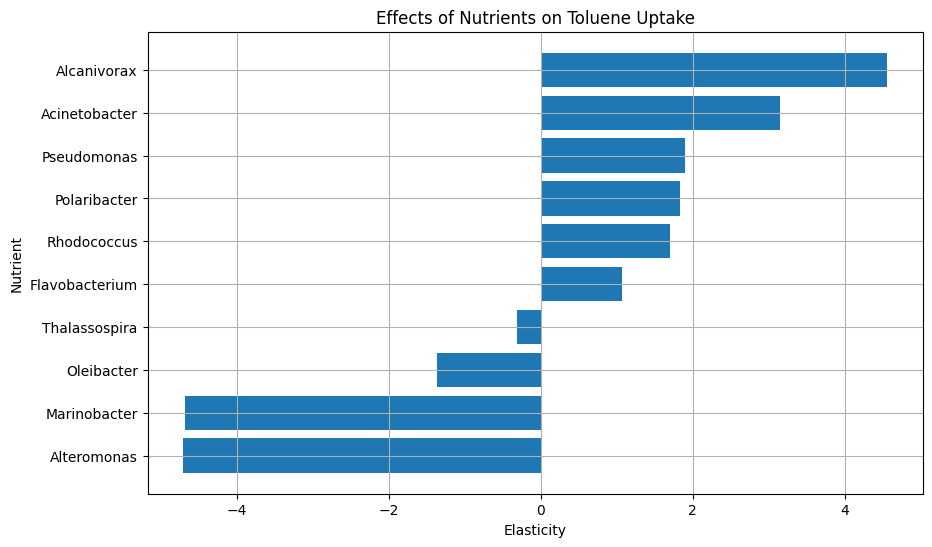

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

elasticities_df = pd.read_csv('results/micom/elasticities.tsv', sep='\t')
toluene_intake_taxa_effects = elasticities_df[
    (elasticities_df['reaction'] == 'EX_tol_m') &
    (elasticities_df['direction'] == 'reverse') & 
    (elasticities_df['type'] == 'abundance')
    ]
toluene_intake_taxa_effects = toluene_intake_taxa_effects.sort_values(by='elasticity', ascending=True)
taxa = toluene_intake_taxa_effects['effector']
elasticities = toluene_intake_taxa_effects['elasticity']

plt.figure(figsize=(10, 6))
plt.barh(taxa, elasticities)
plt.xlabel('Elasticity')
plt.ylabel('Nutrient')
plt.title('Effects of Nutrients on Toluene Uptake')
plt.grid(True)
plt.show()

The results from the toluene intake effects analysis show how an increase in the abundance of each different taxon in the community affects the uptake of toluene by _Acinetobacter_. Note that, by default, the uptake of a compound in an exchange reaction corresponds to the reverse direction, thus negative flux values. On the other hand, a positive elasticity value indicates that there is direct relationship between the abundance of the taxon and the uptake of toluene, while a negative elasticity indicates an inverse relationship.

In this case, the majority of taxa exert a positive effect on toluene uptake by _Acinetobacter_. This is likely due to the metabolites that these taxa excrete to the environment, which are taken up by _Acinetobacter_ and support its growth. However, there are also some taxa that have a negative effect on toluene uptake, notably _Alternomonas_ and _Marinobacter_, this effect could be due to competition for substrates between these taxa and _Acinetobacter_.

Conducting a sensitivity or elasticity analysis can be very informative. With a simple run we have identified taxa that either support or hampers the uptake of our target environmental pollutant. Armed with this information, we could design bioremediation/bioaugmentation strategies to optimize community uptake of toluene, either by directly reducing a particular taxon (e.g. through a taxon-specific virus) or by manipulating environmental conditions so they are less favorable to the competing taxon.

### Analyzing the effects of external nutrients on toluene degradation: Biostimulation

In addition to the effects of different taxa on toluene degradation, we can also analyze the effects of external nutrients on toluene uptake. This analysis is useful for understanding the role of different nutrients in the community's metabolism and for identifying potential levers for modulating toluene uptake. For example, we can use this analysis to identify nutrients that promote toluene uptake by _Acinetobacter_, which could be used to optimize the bioremediation of oil spills by a process known as biostimulation.

Negative elasticity values indicate that increasing the uptake rate of the nutrient would increase toluene uptake by _Acinetobacter_. The larger the absolute value of the elasticity, the larger the effect of the nutrient on toluene uptake. Therefore, nutrients with large negative elasticity values could be added to the environment as part of a biostimulation strategy to enhance the bioremediation of toluene by promoting its uptake by _Acinetobacter_. 

However, it's important to consider the potential side effects of adding these nutrients to the environment, as they could also affect other processes and organisms in the ecosystem. Therefore, any biostimulation strategy should be carefully planned and monitored to ensure it achieves the desired effect without causing unintended harm.

Let's plot the elasticity values for all original nutrients in the environment with respect to the toluene uptake rate by _Acinetobacter_.

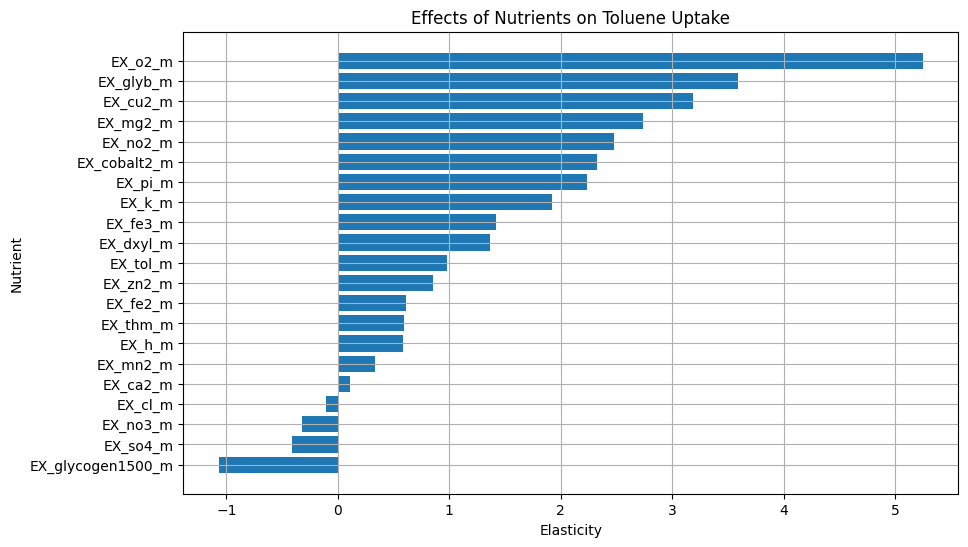

In [15]:
import matplotlib.pyplot as plt

toluene_intake_nutrient_effects = elasticities_df[
    (elasticities_df['reaction'] == 'EX_tol_m') &
    (elasticities_df['direction'] == 'reverse') & 
    (elasticities_df['type'] == 'exchanges')
    ]
toluene_intake_nutrient_effects = toluene_intake_nutrient_effects.sort_values(by='elasticity', ascending=True)
nutrients = toluene_intake_nutrient_effects['effector']
elasticities = toluene_intake_nutrient_effects['elasticity']

plt.figure(figsize=(10, 6))
plt.barh(nutrients, elasticities)
plt.xlabel('Elasticity')
plt.ylabel('Nutrient')
plt.title('Effects of Nutrients on Toluene Uptake')
plt.grid(True)
plt.show()

From the results above, we can see that most nutrients have a positive effect on toluene uptake, with the exception of chloride (Cl), nitrate (no3), sulphate (so4) and glycogen -- while out of the scope of this notebook, is interesting to see that glycogen exerts a negative effect on toluene uptake, this may be due to competition between carbon sources. Based on this analysis, we could run a biostimulation experiment by adding some of the nutrients with the largest impact on toluene uptake by `Acinetobacter`. In this case, we must first carefully consider the potential side effects of adding these nutrients to the environment. 

Thanksfully, we can simulate such biostimulation experiment _in silico_ by increasing the allowed maximum uptake rate of the selected nutrients with positive elasticity values. Let's do it next!

## Increasing toluene uptake through biostimulation

Alrigth, now that we have identified potential nutrients that could be added to the environment to enhance the bioremediation of toluene, let's design a biostimulation strategy to increase toluene uptake by `Acinetobacter`. To this end, we will increase the uptake rate of the first five nutrients with the largest effect on toluene uptake (exluding $O_2$): `Glycinebetaine` (glyb), `Copper` (cu2), `Magnesium` (Mg2+), `Nitrite` (no2), and `Cobalt` (cobalt2). We will then simulate the growth of the community in this new medium and compare toluene uptake rates with the ones obtained with the original escenario.

In [30]:
# Find n largest nutrient effectors
n = 6
largest_nutrient_effectors = toluene_intake_nutrient_effects.nlargest(n, 'elasticity').effector.to_list()
largest_nutrient_effectors

['EX_o2_m', 'EX_glyb_m', 'EX_cu2_m', 'EX_mg2_m', 'EX_no2_m', 'EX_cobalt2_m']

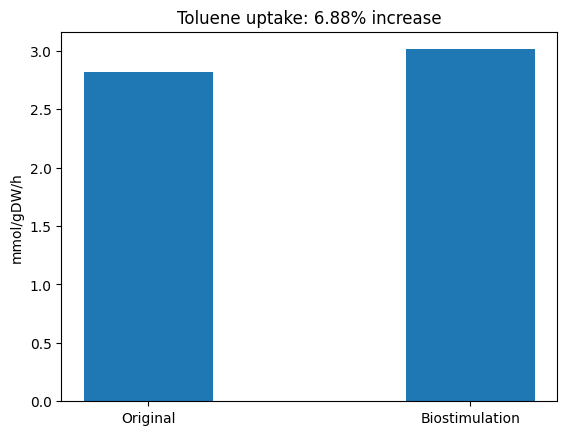

In [31]:
import matplotlib.pyplot as plt

# Reset medium
cgem.medium = medium.set_index('reaction').squeeze()
cgem.optimize()

# Simulate additon of nutrients to increase toluene uptake
toluene_uptake = cgem.reactions.get_by_id('EX_tol_m')
old_toluene_uptake_rate = toluene_uptake.flux

# Open exchanges of selected nutrients
selected_nutrients = largest_nutrient_effectors[1:]
for rxn_id in selected_nutrients:
    cgem.reactions.get_by_id(rxn_id).bounds = (-1000, 1000)

# Update optimization
cgem.optimize()
new_toluene_uptake_rate = toluene_uptake.flux

# Plot uptake changes
pct_change = round((new_toluene_uptake_rate - old_toluene_uptake_rate) / old_toluene_uptake_rate * 100, 2)
plt.bar(['Original', 'Biostimulation'], [-old_toluene_uptake_rate, -new_toluene_uptake_rate], width=0.4)
plt.ylabel('mmol/gDW/h')
plt.title(f'Toluene uptake: {pct_change}% increase')
plt.show()

After the simulated biostimulation strategy, toluene uptake has increased by 7% compared to the original community. This is a significant increase, and shows that biostimulation can be a powerful tool for enhancing the bioremediation of oil spills by increasing the uptake of toxic compounds by microbial communities.

## Conclusions

In this notebook, we have used a community genome-scale metabolic model to investigate the trophic network that emerges post a marine coastal oil spill. Additionally, we have employed constraint-based modeling techniques, including Flux Balance Analysis (FBA) and elasticities to identify both taxa and environmental nutrients that bear the potential to improve the degradation of toxic compounds. Finally, based on the gained knowledge, we have designed a biostimulation strategy by adding key nutrients to he medium to enhance the bioremediation potential of the community.